In [243]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [244]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2
from PIL import Image
import requests

In [0]:
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

In [0]:
X_train = train_data['features']
y_train = train_data['labels']

X_val = val_data['features']
y_val = val_data['labels']

X_test = test_data['features']
y_test = test_data['labels']



In [251]:
print(X_train.shape,X_val.shape,X_test.shape)


(34799, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]),'The no. of images is not equal to the no. of labels'
assert(X_test.shape[0] == y_test.shape[0]),'The no. of images is not equal to the no. of labels'
assert(X_val.shape[0] == y_val.shape[0]),'The no. of images is not equal to the no. of labels'
assert(X_train.shape[1:] == (32,32,3)),'The dimensions of the image  are not equal to 32 x 32 x 3'
assert(X_val.shape[1:] == (32,32,3)),'The dimensions of the image  are not equal to 32 x 32 x 3'
assert(X_test.shape[1:] == (32,32,3)),'The dimensions of the image  are not equal to 32 x 32 x 3'


In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
# print(type(data),data)
#x_selected = X_train[y_train == 31]
#print(x_selected[3,:,:,0])

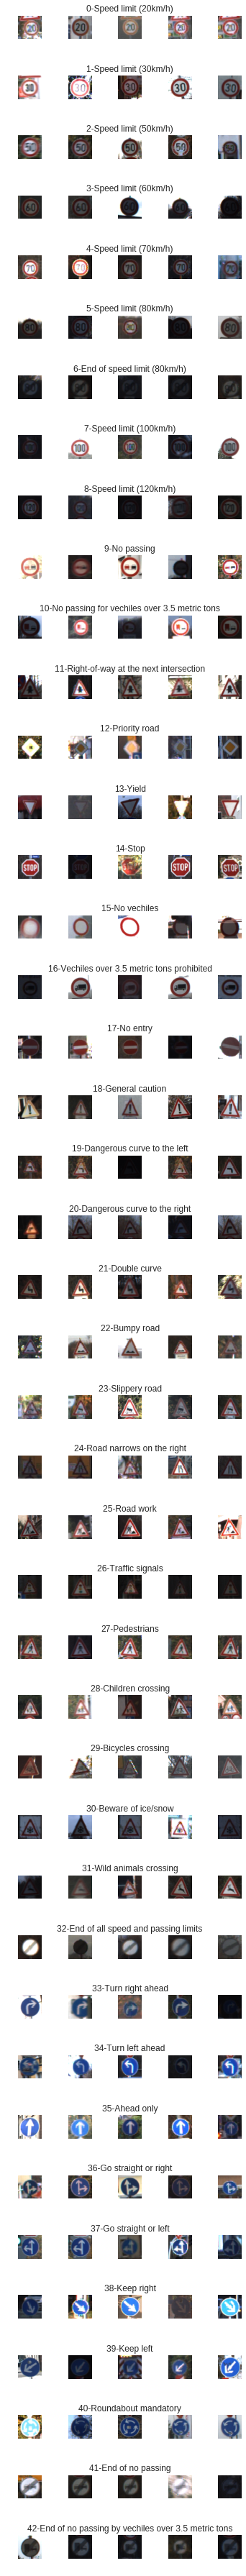

In [254]:
num_of_samples =  []
cols = 5
num_classes = 43

fig,axs = plt.subplots(num_classes,cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1),:,:],cmap = plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i==2:
      axs[j][i].set_title(str(j) + '-' + row['SignName'])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


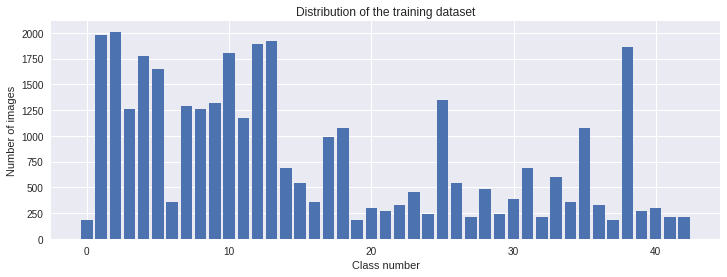

In [255]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

plt.show()

In [0]:
def grayscale(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return gray
  
def equalize(gray):   
  img = cv2.equalizeHist(gray) # it will only take gray scale images and distribute the intensity over whole and increases the brightness of the images
  return img

def preprocessing(img):
  img =  grayscale(img)
  img = equalize(img)
  img = img/255  # this  is called normalisation to make data b/w 0-1
  return img


  



In [0]:
X_train = np.array(list(map(preprocessing,X_train)))
X_val = np.array(list(map(preprocessing,X_val)))
X_test = np.array(list(map(preprocessing,X_test)))

In [0]:
X_train = X_train.reshape(34799, 32, 32,1)
X_val = X_val.reshape(4410, 32, 32,1)
X_test = X_test.reshape(12630, 32, 32,1)


In [0]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                  height_shift_range=0.1,
                  zoom_range=0.2,
                  shear_range=0.1,
                  rotation_range=10)

datagen.fit(X_train)

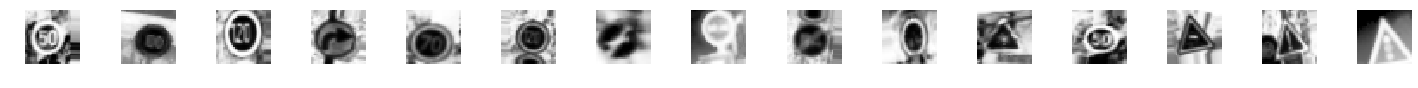

In [271]:
batches = datagen.flow(X_train,y_train,batch_size = 20)
X_batch,y_batch = next(batches)

fig,axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [0]:
# One Hot Encoding for labels
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)
y_test = to_categorical(y_test,43)

In [0]:
# CONVOLUTIONAL NEURAL NETWORK MODEL LE-NET

def modified_net():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(units = 500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation ='softmax'))
  # COMPILE MODEL
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  
  return model

In [261]:
model = modified_net()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 480)               0         
__________

In [262]:
history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,verbose=1,shuffle=1,validation_data=(X_val,y_val))

Epoch 1/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.9117 - acc: 0.7333 - val_loss: 0.0923 - val_acc: 0.9703
Epoch 2/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.2053 - acc: 0.9355 - val_loss: 0.0408 - val_acc: 0.9887
Epoch 3/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.1383 - acc: 0.9572 - val_loss: 0.0708 - val_acc: 0.9764
Epoch 4/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.1048 - acc: 0.9674 - val_loss: 0.0533 - val_acc: 0.9866
Epoch 5/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0916 - acc: 0.9717 - val_loss: 0.0689 - val_acc: 0.9848
Epoch 6/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0803 - acc: 0.9754 - val_loss: 0.0491 - val_acc: 0.9882
Epoch 7/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0740 - acc: 0.9777 - val_loss: 0.0293 - val_acc: 0.9909
Epoch 8/10
2000/2000 [==========================

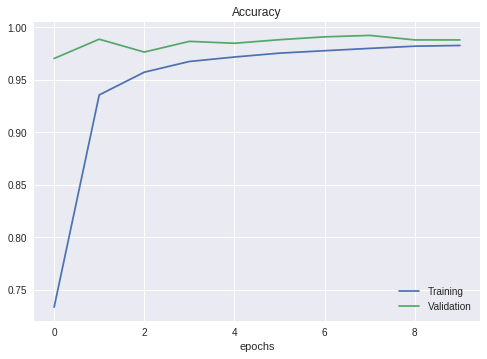

In [263]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training','Validation'])
plt.xlabel('epochs')
plt.title('Accuracy')
plt.show()

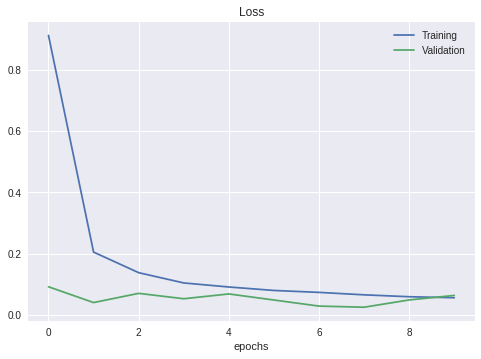

In [264]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.xlabel('epochs')
plt.title('Loss')
plt.show()

In [265]:
score = model.evaluate(X_test,y_test)
print('Test Score :',score[0],'Test Accuracy :',score[1])

12630/12630 [==============================] - 2s 139us/step
Test Score : 0.09202397606311016 Test Accuracy : 0.9751385590054171


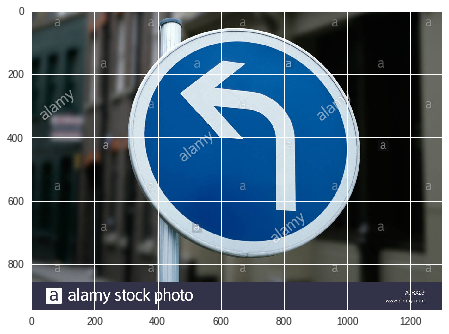

In [266]:
#fetch data
#url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
#url ='https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
#url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
#url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
response = requests.get(url,stream=True)
img = Image.open(response.raw)
plt.imshow(img,cmap = plt.get_cmap('gray'))

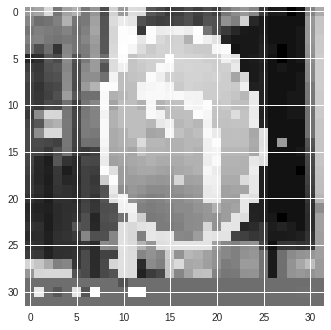

In [267]:
# Preprocessing image
img = np.asarray(img)
img = cv2.resize(img,(32,32))
img = preprocessing(img)
plt.imshow(img,cmap = plt.get_cmap('gray'))


In [0]:
img = np.reshape(img,(1,32,32,1))


In [269]:
predict = model.predict_classes(img)
print("predict :",str(predict),data['SignName'][predict])

predict : [34] 34    Turn left ahead
Name: SignName, dtype: object
